In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

# Time Series Forecasting wih Prophet

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with <strong>daily periodicity data</strong> with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers. - <a href="https://facebookincubator.github.io/prophet/">Prophet</a>

## The Model

Forecasting in the domain of Prophet is a curve-fitting task. The underlying model has an additive form

$$
y(t) = d(t) + s(t) + h(t) + \varepsilon_t
$$

where $d(t)$ denotes a trend function modeling non-periodic changes, $s(t)$ denotes seasonality modeling periodic changes and $h(t)$ representing the effects of holidays. This model assumes time as its only regressor, however, linear and non-linear transformations are included if it increases the models fit. Hence, 

In [2]:
from fbprophet import Prophet

The input to Prophet is always a dataframe with two columns: <code>ds</code> and <code>y</code>. The <code>ds</code> (datestamp) column must contain a date or datetime (either is fine). The <code>y</code> column must be numeric, and represents the measurement to forecast.

In [3]:
df = pd.read_csv('./data/passengers.csv', sep=';', header=0, parse_dates=True)

# create new coumns, specific headers needed for Prophet
df['ds'] = df['month']
df['y'] = pd.DataFrame(df['n_passengers'])
df.pop('month')
df.pop('n_passengers')

0      112
1      118
2      132
3      129
4      121
5      135
6      148
7      148
      ... 
136    472
137    535
138    622
139    606
140    508
141    461
142    390
143    432
Name: n_passengers, Length: 144, dtype: int64

<code>Prophet</code> assume an additive  time series model and thus, the data is transformed using the log operator of <code>numpy</code>.

In [4]:
df['y'] = pd.DataFrame(np.log(df['y']))
df.head()

,ds,y
0,1949-01,4.71850
1,1949-02,4.77068
2,1949-03,4.88280
3,1949-04,4.85981
4,1949-05,4.79579


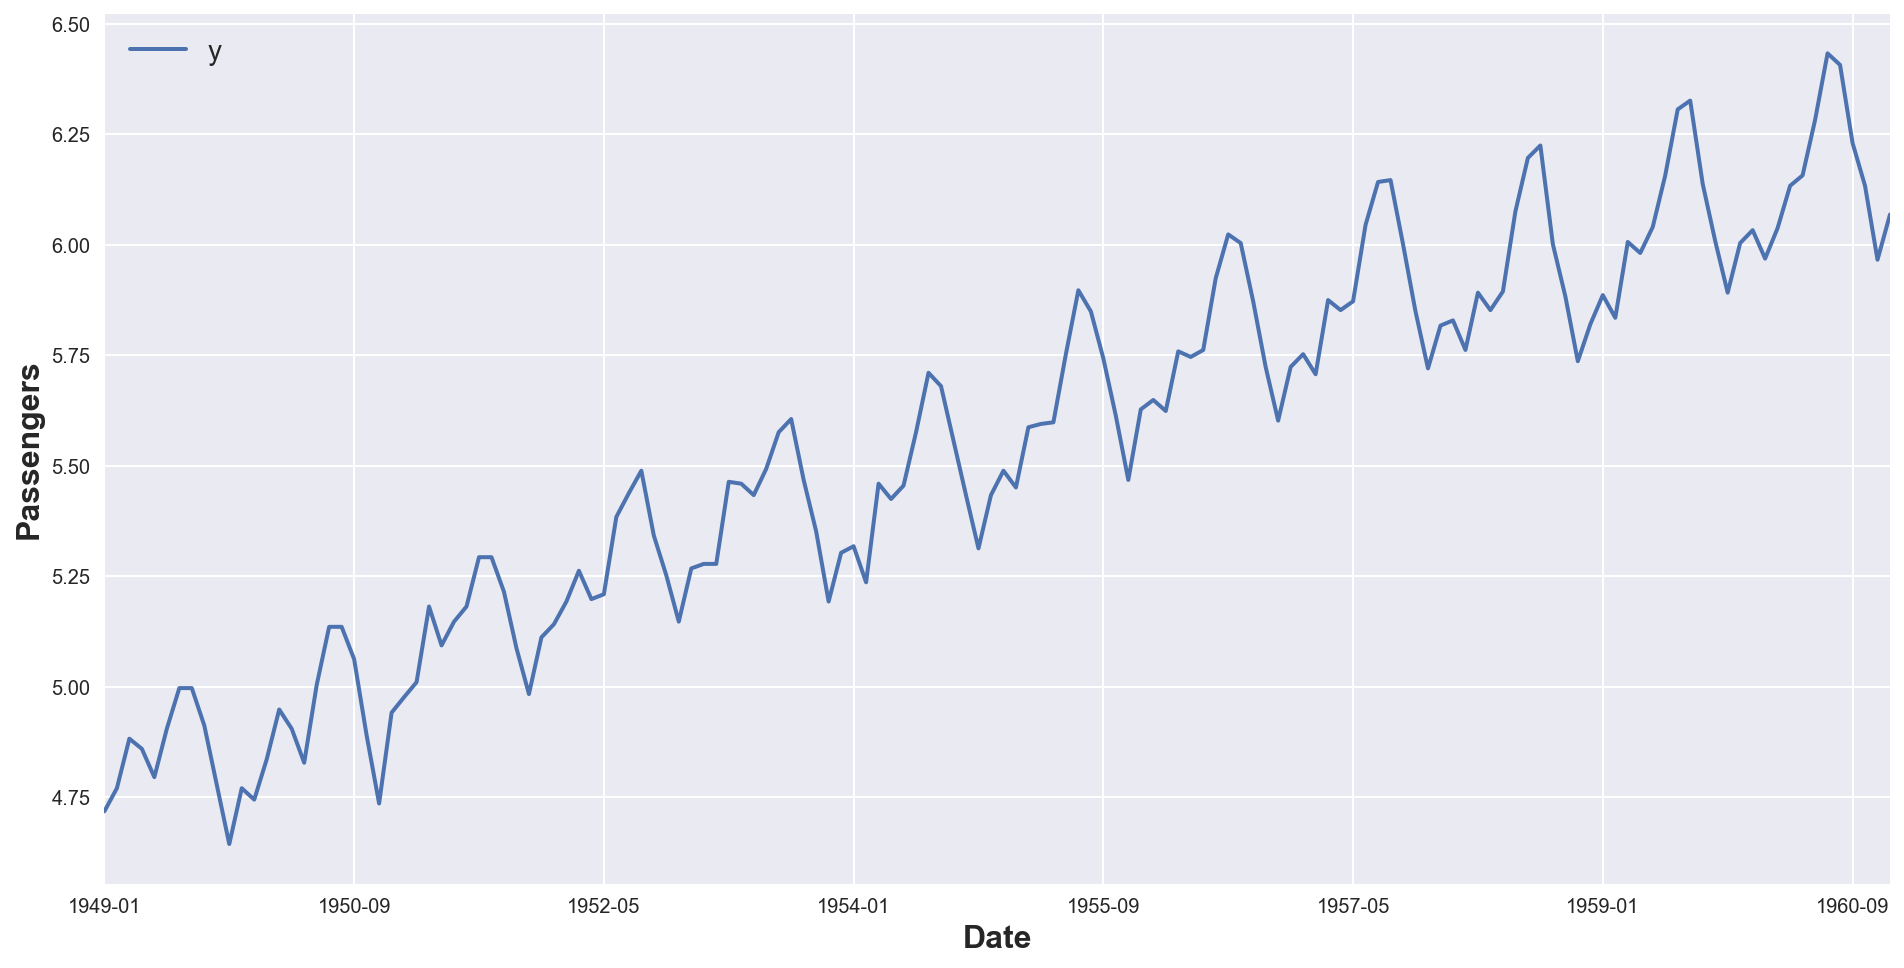

In [5]:
ax = df.set_index('ds').plot();
ax.set_ylabel('Passengers');
ax.set_xlabel('Date');

plt.show()

In [6]:
# train test split
df_train = df[:120]
df_test = df[120:]

In [7]:
mdl = Prophet(interval_width=0.95)

In [8]:
# fit the model on the training data
mdl.fit(df_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
# define future time frame
future = mdl.make_future_dataframe(periods=24, freq='MS')
future.tail()

,ds
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01
143,1960-12-01


The <code>predict</code> method assigns each row in future a predicted value <code>yhat</code>.

In [12]:
# generate the forecast
forecast = mdl.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,6.27984,6.15547,6.41799
140,1960-09-01,6.13677,6.01866,6.27639
141,1960-10-01,6.01055,5.86644,6.15816
142,1960-11-01,5.88457,5.74336,6.03912
143,1960-12-01,5.99797,5.85185,6.16617


<code>mdl</code> is a <code>Prophet</code> object and and can be plotted with predefined settings

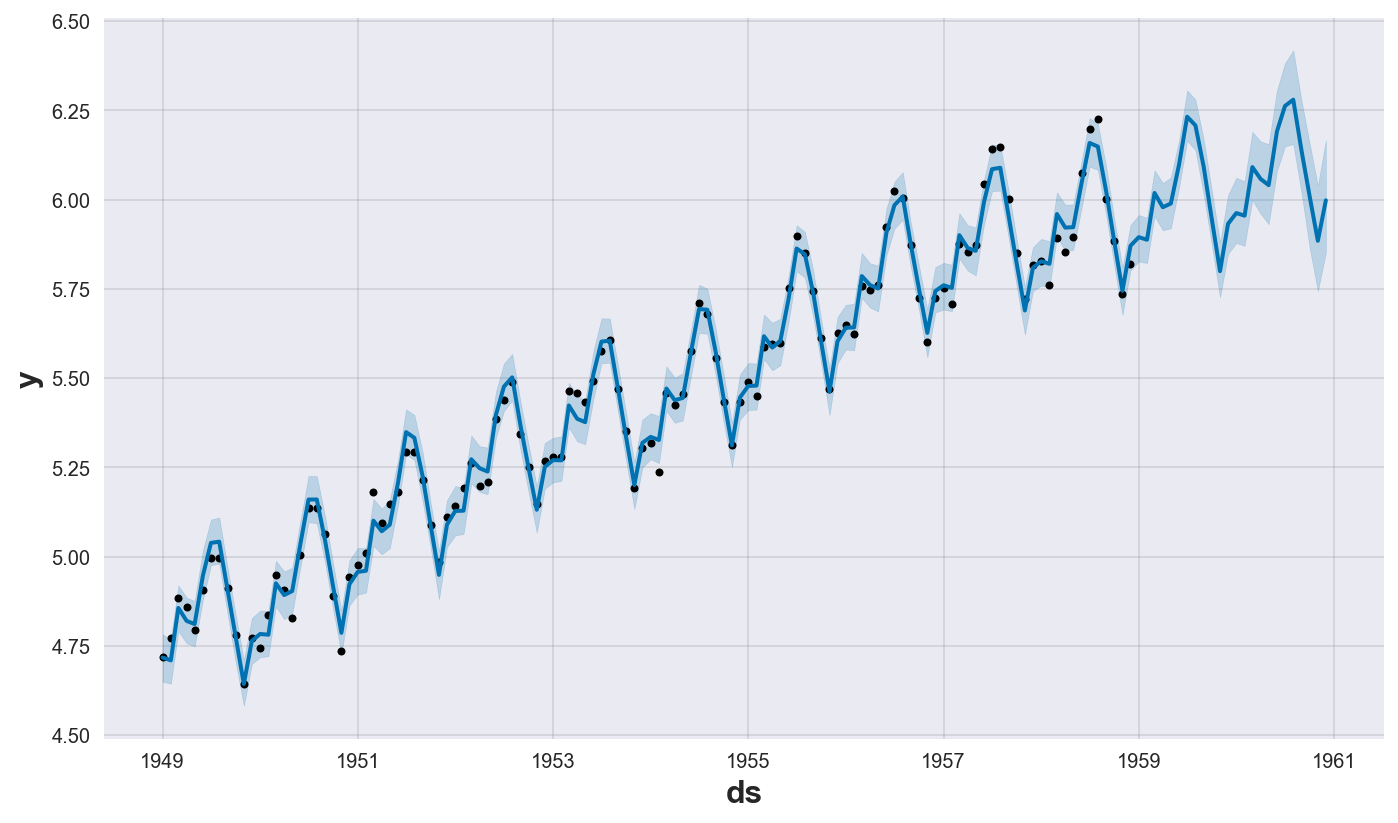

In [13]:
mdl.plot(forecast);
plt.show()

Similar to the <code>statsmodels</code> module a time series decomposition method is available.

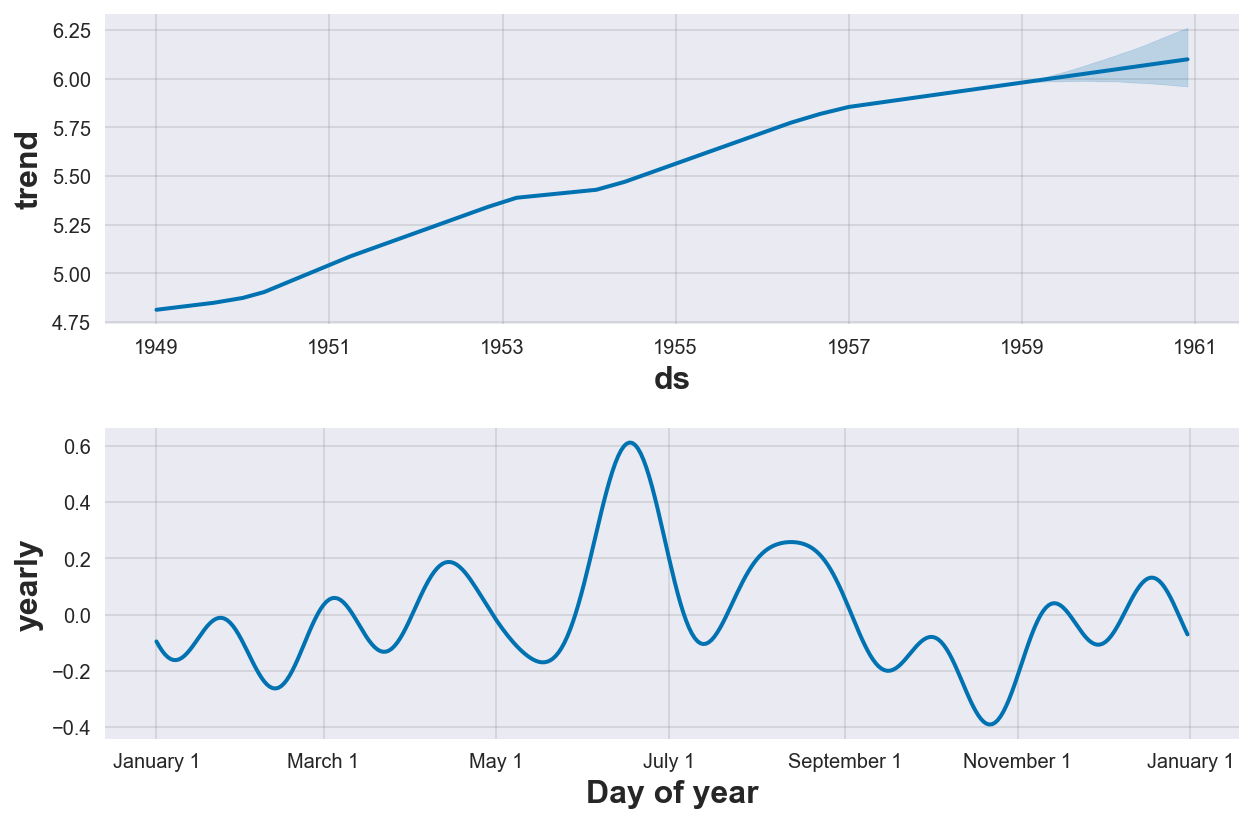

In [14]:
# plot time series components
mdl.plot_components(forecast);
plt.show()

In [16]:
# retransform using e
y_hat = np.exp(forecast['yhat'][120:])
y_true = np.exp(df_test['y'])

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 1610.75 MSE (40.13 RMSE)


In [17]:
# prepare data for plotting
#.reindex(pd.date_range(start='1959-01-01', end='1960-12-01', freq='MS'))
#.reindex(pd.date_range(start='1949-01-01', end='1960-12-01', freq='MS'))
y_hat_plot = pd.DataFrame(y_hat)
y_true_plot = pd.DataFrame(np.exp(df['y']))

In [18]:
len(pd.date_range(start='1959-01-01', end='1960-12-01', freq='MS'))

24

In [19]:
y_true_plot

,y
0,112.00000
1,118.00000
2,132.00000
3,129.00000
4,121.00000
5,135.00000
6,148.00000
7,148.00000
...,...
136,472.00000


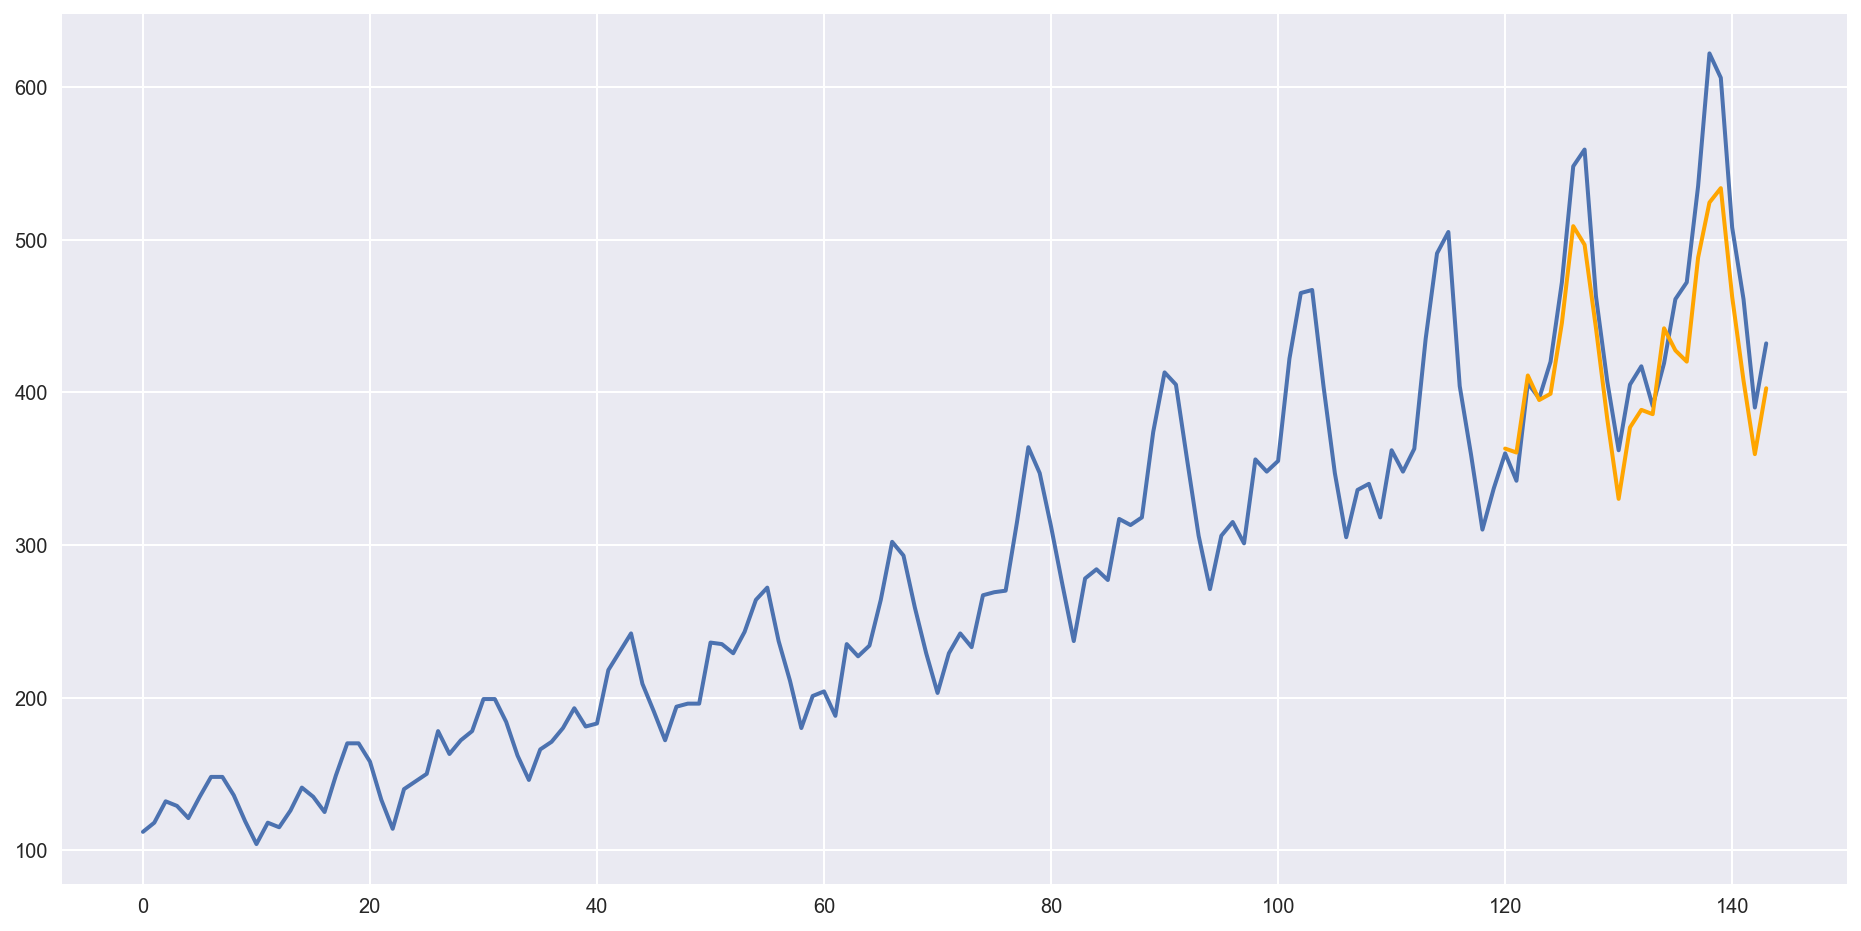

In [20]:
plt.plot(y_true_plot, label='Original');
plt.plot(y_hat_plot, color='orange', label='Forecast');
ax.set_ylabel('Passengers');
ax.set_xlabel('Date');

plt.show()